# Feature Adversaries Attack in TensorFlow v2

Before diving into the attack, let's first prepare a classification model. We utilize a script from the `examples` folders.

In [1]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist

# Step 1: Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 2: Create the model
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

/Users/wenjinzhang/opt/anaconda3/envs/UAP/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/wenjinzhang/opt/anaconda3/envs/UAP/lib/python3.8/site-packages/art/estimators/certification/__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [2]:
# Step 3: Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

# Step 4: Train the ART classifier
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Train on 60000 samples
Epoch 1/3


2022-07-28 13:06:40.844934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 13:06:40.879874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


60000/60000 [==============================] - 9s 156us/sample - loss: 0.1663 - accuracy: 0.9498
Epoch 2/3
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0839 - accuracy: 0.9746
Epoch 3/3
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0765 - accuracy: 0.9775


/Users/wenjinzhang/opt/anaconda3/envs/UAP/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on benign test examples: 97.72%


In [24]:
from art.attacks.evasion import UniversalPerturbation

adv_crafter = UniversalPerturbation(
    classifier,
    attacker='fgsm',
    delta=0.2,
    attacker_params={'targeted':True, 'eps':0.6},
    max_iter=10,
    eps=5.5,
    norm=2)

x_adv = adv_crafter.generate(x=x_test)



attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)


# Step 7: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 73.38%


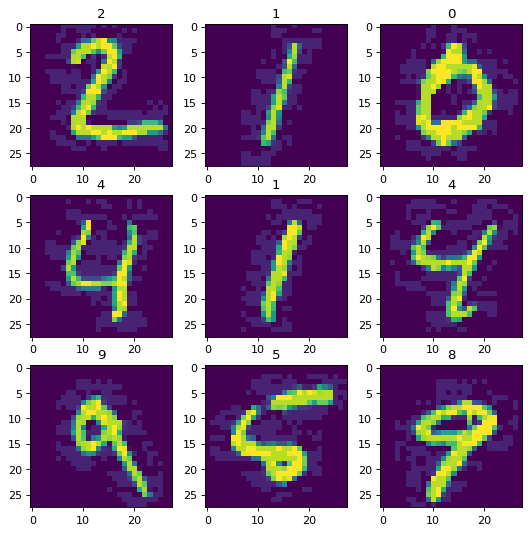

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8), dpi=80)

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_test_adv[i])
    plt.title(np.argmax(predictions[i]))

In [11]:
from art.attacks.evasion import TargetedUniversalPerturbation
adv_crafter = TargetedUniversalPerturbation(
    classifier,
    attacker='fgsm',
    delta=0.2,
    attacker_params={'targeted':True, 'eps':0.6},
    max_iter=10,
    eps=5.5,
    norm=2)

In [12]:
# selecting 1000 images for each class in 10 classes 
x_part_train = x_train[:100*10]
y_part_train = y_train[:100*10]

# set target label
target = 1
y_train_adv_tar = np.zeros(y_part_train.shape)
for i in range(y_part_train.shape[0]):
    y_train_adv_tar[i, target] = 1.0

In [ ]:
x_adv = adv_crafter.generate(x_part_train, y=y_train_adv_tar)

In [10]:
noise = adv_crafter.noise[0,:]
x_train_adv = x_train + noise
x_test_adv = x_test + noise

preds_train_adv = np.argmax(classifier.predict(x_train_adv), axis=1)
preds_test_adv = np.argmax(classifier.predict(x_test_adv), axis=1) 
targeted_success_rate_train = np.sum(preds_train_adv == target) / len(x_train)
targeted_success_rate_test = np.sum(preds_test_adv == target) / len(x_test) 
print('targeted_success_rate_train: {:.1f} %'.format(targeted_success_rate_train*100))
print('targeted_success_rate_test: {:.1f} %'.format(targeted_success_rate_test*100))

targeted_success_rate_train: 9.7 %
targeted_success_rate_test: 9.8 %
